In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
sns.set()

from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

seed = 42

In [2]:
df = pd.read_csv('Absenteeism-data.csv')
df.head()

,ID,Reason for Absence,Date,Transportation Expense,Distance to Work,Age,Daily Work Load Average,Body Mass Index,Education,Children,Pets,Absenteeism Time in Hours
0,11,26,07/07/2015,289,36,33,239.554,30,1,2,1,4
1,36,0,14/07/2015,118,13,50,239.554,31,1,1,0,0
2,3,23,15/07/2015,179,51,38,239.554,31,1,0,0,2
3,7,7,16/07/2015,279,5,39,239.554,24,1,2,0,4
4,11,23,23/07/2015,289,36,33,239.554,30,1,2,1,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         700 non-null    int64  
 1   Reason for Absence         700 non-null    int64  
 2   Date                       700 non-null    object 
 3   Transportation Expense     700 non-null    int64  
 4   Distance to Work           700 non-null    int64  
 5   Age                        700 non-null    int64  
 6   Daily Work Load Average    700 non-null    float64
 7   Body Mass Index            700 non-null    int64  
 8   Education                  700 non-null    int64  
 9   Children                   700 non-null    int64  
 10  Pets                       700 non-null    int64  
 11  Absenteeism Time in Hours  700 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 65.8+ KB


In [4]:
df.isnull().sum()
#No Outliers

ID                           0
Reason for Absence           0
Date                         0
Transportation Expense       0
Distance to Work             0
Age                          0
Daily Work Load Average      0
Body Mass Index              0
Education                    0
Children                     0
Pets                         0
Absenteeism Time in Hours    0
dtype: int64

# EDA

#### Dependent Variable

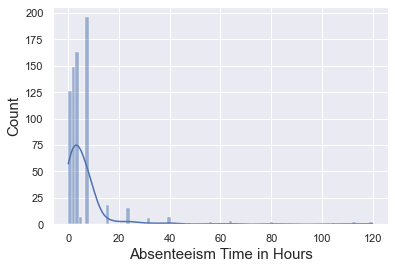

In [5]:
sns.histplot(df['Absenteeism Time in Hours'], kde = True);

In [6]:
df['Absenteeism Time in Hours'].value_counts()
#employees absent hours varies.

8      195
2      149
3      106
1       87
4       57
0       39
16      18
24      15
40       7
5        7
32       6
64       3
112      2
56       2
80       2
120      2
48       1
7        1
104      1
Name: Absenteeism Time in Hours, dtype: int64

In [7]:
df['Absenteeism Time in Hours'].median()

3.0

Creating new target columns where those absent **above 3 hours are considered excessive 
absentees and those equal to or below 3 hours are not excessive absentees**.

In [8]:
df['target'] = np.where(df['Absenteeism Time in Hours'] > df['Absenteeism Time in Hours'].median(), 1, 0).\
                                                                                            astype('int64')

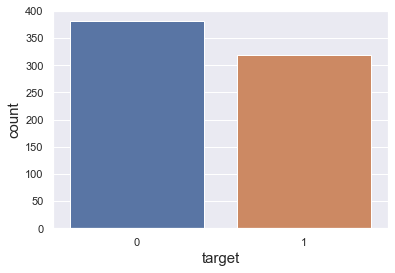

In [9]:
sns.countplot(df['target']);

In [10]:
print(f'Number of normal Absentees: {df["target"].value_counts()[0]}') 
print(f'Proportion of normal absentees: {np.round(df["target"].value_counts(normalize = True)[0]*100,2)} %')
print()
print(f'Number of excessive Absentees: {df["target"].value_counts()[1]}') 
print(f'Proportion of excessive absentees: {np.round(df["target"].value_counts(normalize = True)[1]*100,2)} %')

Number of normal Absentees: 381
Proportion of normal absentees: 54.43 %

Number of excessive Absentees: 319
Proportion of excessive absentees: 45.57 %


The target columns in roughly imbalanced, hence approproate metrics such as F1 score, Roc_auc score, etc, would be suitable for estimating the right model.

#### Extracting features from Date  columns

In [11]:
#Converting Date feature to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [12]:
#train
df['Day'] = df['Date'].dt.dayofweek #The day of the week with Monday=0, Sunday=6.
df['Month'] = df['Date'].dt.month #JAn = 1, Dec = 12
df['Year'] = df['Date'].dt.year

In [13]:
df['Day'].value_counts(normalize = True)*100

2    19.285714
0    18.000000
4    17.428571
3    17.000000
1    16.571429
6     6.571429
5     5.142857
Name: Day, dtype: float64

Sat and Sun has the least proportion of absenteeism. But both of these days are weekends. Hence, removing these 2 days from the observations.

In [14]:
df = df[(df['Day']!=5) & (df['Day']!=6)]

In [15]:
df.reset_index(drop = True, inplace = True)

In [16]:
y = df['target'].to_frame()

df.drop('target', axis = 1, inplace = True)

### Splitting to train and test sets

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = seed)

In [18]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(556, 15)
(62, 15)
(556, 1)
(62, 1)


# Feature Engineering

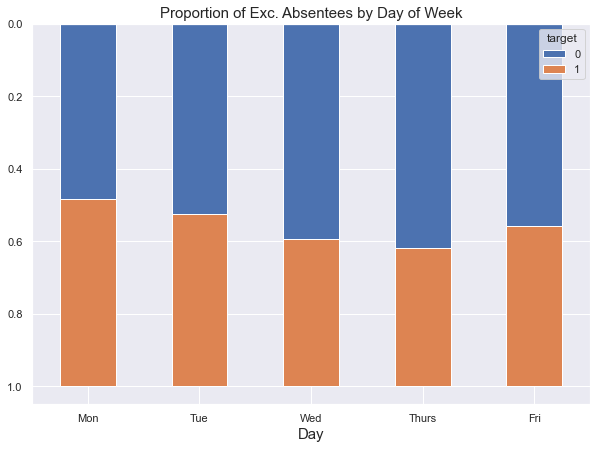

In [19]:
#Plotting excessive absentees according to day of week.

label = ['Mon', 'Tue', 'Wed', 'Thurs', 'Fri']

pd.crosstab(index = X_train['Day'], columns = y_train['target']).apply(lambda r: r/r.sum(), axis=1).\
    plot(kind = 'bar', stacked = True, rot = 0, title = 'Proportion of Exc. Absentees by Day of Week', 
         figsize = (10,7));

plt.gca().invert_yaxis();

plt.xticks(np.arange(0,5,1), labels = label);

Excessive absenteeism is highest on Monday, followed by Tuesday. On wednesday and thursday it drops subsequenty, but then increases slightly again on friday.

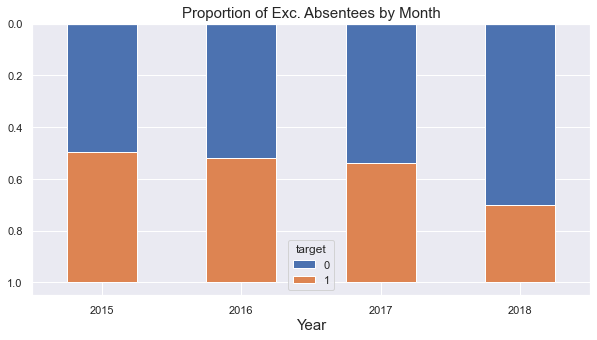

In [20]:
#Plotting excessive absentees according to Month of week.

pd.crosstab(index = X_train['Year'], columns = y_train['target']).apply(lambda r: r/r.sum(), axis=1).\
        plot(kind = 'bar', stacked = True, rot = 0, title = 'Proportion of Exc. Absentees by Month', 
            figsize = (10,5));

plt.gca().invert_yaxis();

Excessive absenteeism remained the same through all the years. I will drop this feature as I am confident this feature wont help the model much.

According to :https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work, the database was created with records of absenteeism at work at a courier company in Brazil.

The seasons in Brazil are as follows, according to: https://seasonsyear.com/Brazil#content-1

**Spring**: Sep, Oct, Nov

**Summer**: Dec, Jan, Feb

**Autumn**: Mar, Apr, May

**Winter**: Jun. Jul, Aug

In [21]:
#Train
X_train['Seasons'] = np.where(X_train['Month'].isin([9,10,11]), 'Spring', 
                         np.where(X_train['Month'].isin([12,1,2]), 'Summer', 
                                  np.where(X_train['Month'].isin([3,4,5]), 'Autumn', 'Winter')))

#Test
X_test['Seasons'] = np.where(X_test['Month'].isin([9,10,11]), 'Spring', 
                         np.where(X_test['Month'].isin([12,1,2]), 'Summer', 
                                  np.where(X_test['Month'].isin([3,4,5]), 'Autumn', 'Winter')))

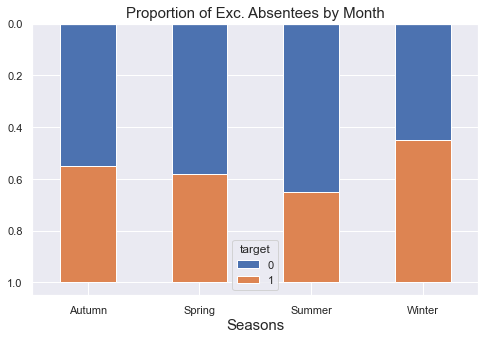

In [22]:
pd.crosstab(index = X_train['Seasons'], columns = y_train['target']).apply(lambda r: r/r.sum(), axis=1).\
        plot(kind = 'bar', stacked = True, rot = 0, title = 'Proportion of Exc. Absentees by Month', 
             figsize = (8,5));

plt.gca().invert_yaxis();

Absenteeism is higher during winter followed by Autumn.

In [23]:
import calendar
X_train['Month_name'] = X_train['Month'].apply(lambda x: calendar.month_abbr[x])

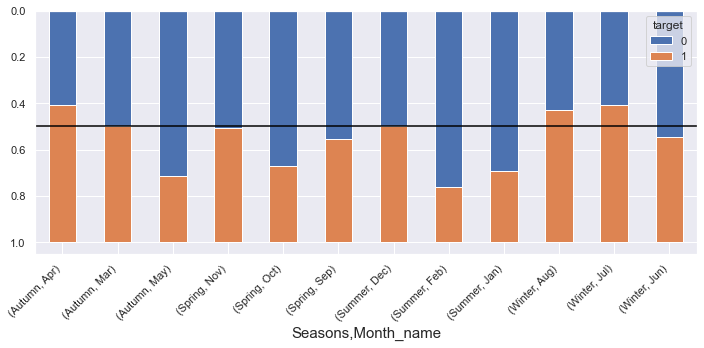

In [24]:
pd.crosstab(index = [X_train.Seasons, X_train.Month_name], columns = y_train.target).\
    apply(lambda x: x/x.sum(), axis = 1).plot(kind = 'bar', stacked = True, figsize = (10,5), rot = 45);

plt.gca().invert_yaxis();
plt.xticks(ha = 'right')
plt.axhline(y = 0.5, color = 'black');
plt.tight_layout();

Excessive Absenteeism is more higher on winter during the months of August and July., followed by April during Autumn season and December suring summer season

#### National Holidays

I have scrapped the national holidays of Brazil through https://www.calendarlabs.com/holidays/brazil/2015 and saved it to a dataframe.

In [25]:
holidays = pd.read_csv('holiday_df.csv')
holidays.head()

,date,holiday_title
0,2015-01-01,New Year's Day
1,2015-02-15,Carnival
2,2015-02-16,Carnival
3,2015-02-17,Carnival
4,2015-02-17,Carnival/Shrove Tuesday


In [26]:
holidays.date = pd.to_datetime(holidays.date)

In [27]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           60 non-null     datetime64[ns]
 1   holiday_title  60 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.1+ KB


I will create a new columns where those dates in df which are shown in holidays will be mapped to 1, the rest 0.

In [28]:
X_train['is_holiday'] = np.where(X_train['Date'].isin(holidays.date),1,0)

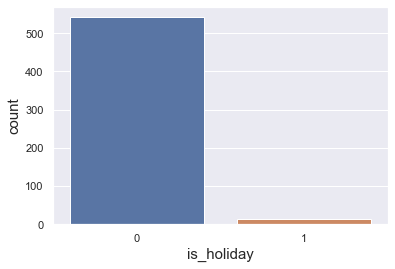

In [29]:
sns.countplot(x = 'is_holiday', data = X_train);

According to the dates in the Absenteeism dataset, only 15 days were natinal holidays. Hence, its highly unlikely this feature would help our model.

#### Reason for Absence

In [31]:
X_train['Reason for Absence'].unique()

array([13, 23, 10, 25,  1, 19, 28, 21, 14,  6, 27,  2, 18,  7, 15, 11, 26,
        0, 22,  4, 12,  5,  3,  9, 17, 16,  8, 24], dtype=int64)

In [32]:
X_train['Reason for Absence'].value_counts()

23    119
28     92
27     56
13     35
0      29
26     28
22     26
19     24
25     22
14     16
10     16
11     16
18     16
1      13
7      10
12      6
21      5
8       5
6       5
9       4
16      3
15      2
4       2
24      2
17      1
5       1
3       1
2       1
Name: Reason for Absence, dtype: int64

According to :https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work, the Reason for absence column is assigned with numbers that signifies the following:

Absences attested by the International Code of Diseases (ICD) stratified into 21 categories (I to XXI) as follows:

I Certain infectious and parasitic diseases

II Neoplasms

III Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism

IV Endocrine, nutritional and metabolic diseases

V Mental and behavioural disorders

VI Diseases of the nervous system

VII Diseases of the eye and adnexa

VIII Diseases of the ear and mastoid process

IX Diseases of the circulatory system

X Diseases of the respiratory system

XI Diseases of the digestive system

XII Diseases of the skin and subcutaneous tissue

XIII Diseases of the musculoskeletal system and connective tissue

XIV Diseases of the genitourinary system

XV Pregnancy, childbirth and the puerperium

XVI Certain conditions originating in the perinatal period

XVII Congenital malformations, deformations and chromosomal abnormalities

XVIII Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified

XIX Injury, poisoning and certain other consequences of external causes

XX External causes of morbidity and mortality

XXI Factors influencing health status and contact with health services.

And 7 categories without (CID) patient follow-up (22), medical consultation (23), blood donation (24), laboratory examination (25), unjustified absence (26), physiotherapy (27), dental consultation (28).

I will now group these reasons to 5 categories

In [33]:
bins = [-1,0.5,14.5,17.5,20.5,29]
reasons = ['Not Absent','Disease', 'Pregnancy', 'Severe', 'Other']

X_train['Reason_bin'] = pd.cut(x = X_train['Reason for Absence'], bins = bins, 
                               labels = reasons, ordered = False).astype('object')

X_test['Reason_bin'] = pd.cut(x = X_test['Reason for Absence'], bins = bins, 
                               labels = reasons, ordered = False).astype('object')

In [34]:
X_train['Reason_bin'].value_counts()

Other         350
Disease       131
Severe         40
Not Absent     29
Pregnancy       6
Name: Reason_bin, dtype: int64

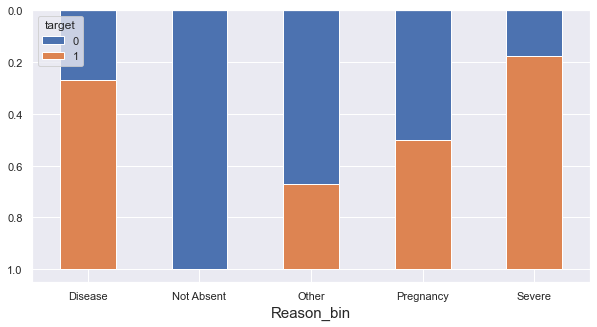

In [35]:
pd.crosstab(index = X_train.Reason_bin, columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
plot(kind = 'bar', stacked = True, rot = 0, figsize = (10,5));

plt.gca().invert_yaxis();

The main reasons for people to be absent were due to Diseases or other Severe reasons.

#### Dependents

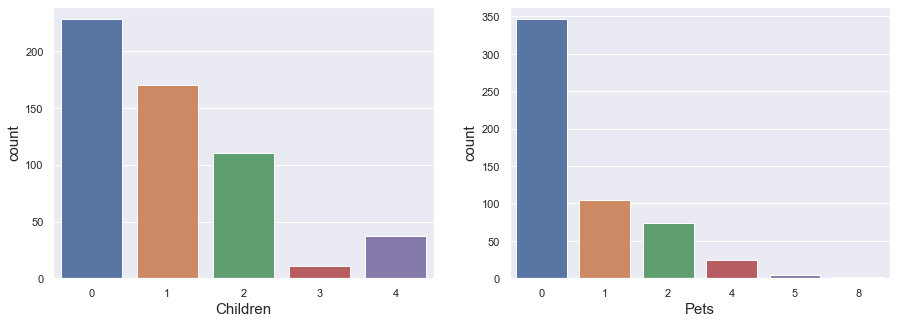

In [36]:
figure, axes = plt.subplots(1,2, figsize = (15,5))

for i, ax in zip(X_train.columns[9:11], axes.flatten()):
    sns.countplot(x = i, data = X_train, ax=ax);

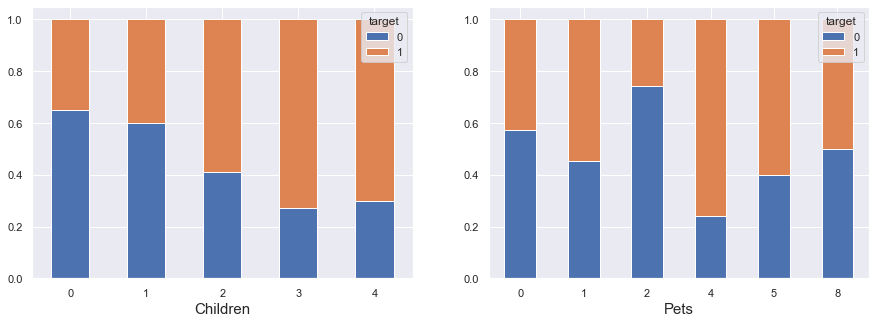

In [37]:
figure, axes = plt.subplots(1,2, figsize = (15,5))

for i, ax in zip(df.columns[9:11], axes.flatten()):
    pd.crosstab(index = X_train[i], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                        plot(kind = 'bar', stacked = True, ax = ax, rot = 0);

Most of the employees dont have any pets or children. The general trend seems that excessive absenteeism is shown by those who have higher number of children or pets. Therefore, a new columns will be creating combining both children and pets.

In [38]:
X_train['Dependents'] = X_train['Children'] + X_train['Pets']

X_test['Dependents'] = X_test['Children'] + X_test['Pets']

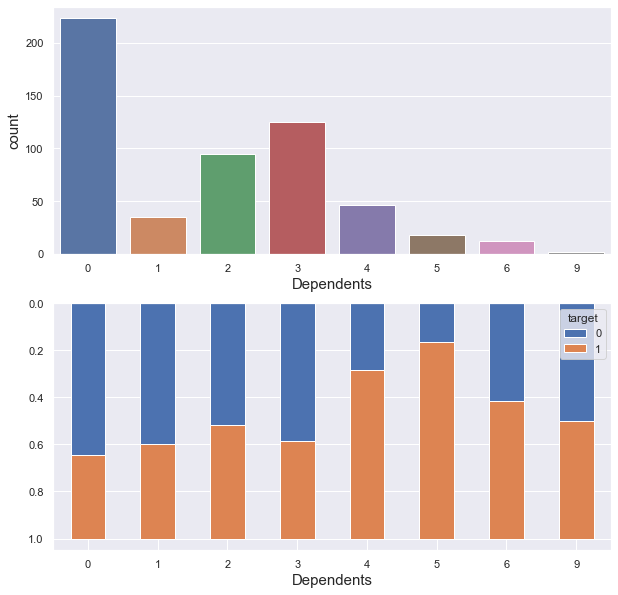

In [39]:
fig, ax = plt.subplots(2,1, figsize = (10,10))

sns.countplot(X_train['Dependents'], ax = ax[0])


pd.crosstab(index = X_train['Dependents'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

There are very few employees with more than 5 dependents. Most of the employees have zero dependents.

Employees who have no dependents or just a single dependent is less liekly to be absent excessively, compared to those who have higher dependents. 

The Dependent variable has high cardinality. Hence, I will reduce this feature to just 3 categories.

0: No dependents

1-2: small size

3 and above: big size


In [40]:
X_train['household_size'] = np.where(X_train['Dependents'] >=3, 'large_size', 
                                np.where(X_train['Dependents']==0, 'empty', 'small_size'))

X_test['household_size'] = np.where(X_test['Dependents'] >=3, 'large_size', 
                                np.where(X_test['Dependents']==0, 'empty', 'small_size'))

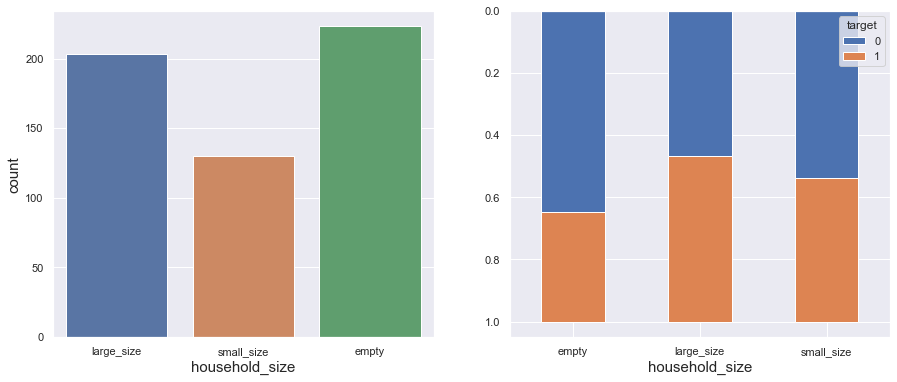

In [41]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

sns.countplot(X_train['household_size'], ax = ax[0])


pd.crosstab(index = X_train['household_size'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

Those who have no dependents (empty household) have less excessive absenteeism compared to others.

#### Education

Education (high school (1), graduate (2), postgraduate (3), master and doctor (4))

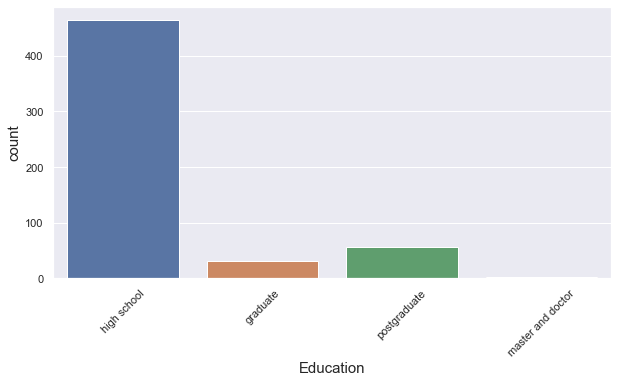

In [42]:
labels = ['high school', 'graduate', 'postgraduate', 'master and doctor']

plt.figure(figsize = (10,5))
sns.countplot(X_train['Education']);
plt.xticks(np.arange(0,4,1), labels, rotation = 45);

Employees with just a high school diploma are higher in numbers compared to those with a college degree. Hence, I will create a new feature where those with college degree will be grouped together to a ssingle category.

In [43]:
X_train['has_collegedegree'] = np.where(X_train['Education'] > 1, 1, 0).astype('int64')
X_test['has_collegedegree'] = np.where(X_test['Education'] > 1, 1, 0).astype('int64')

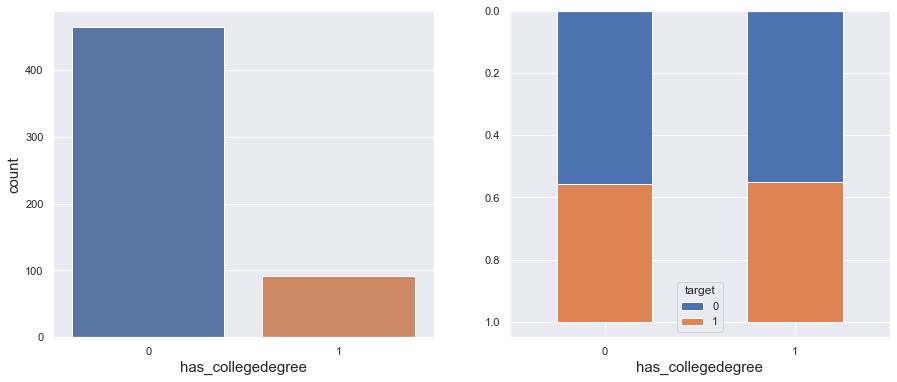

In [44]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

sns.countplot(X_train['has_collegedegree'], ax = ax[0])


pd.crosstab(index = X_train['has_collegedegree'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

it seems that employees with or without college degree has the same proportion of being excessively absent.

In [45]:
X_train.columns

Index(['ID', 'Reason for Absence', 'Date', 'Transportation Expense',
       'Distance to Work', 'Age', 'Daily Work Load Average', 'Body Mass Index',
       'Education', 'Children', 'Pets', 'Absenteeism Time in Hours', 'Day',
       'Month', 'Year', 'Seasons', 'Month_name', 'is_holiday', 'Reason_bin',
       'Dependents', 'household_size', 'has_collegedegree'],
      dtype='object')

In [46]:
X_test.columns

Index(['ID', 'Reason for Absence', 'Date', 'Transportation Expense',
       'Distance to Work', 'Age', 'Daily Work Load Average', 'Body Mass Index',
       'Education', 'Children', 'Pets', 'Absenteeism Time in Hours', 'Day',
       'Month', 'Year', 'Seasons', 'Reason_bin', 'Dependents',
       'household_size', 'has_collegedegree'],
      dtype='object')

In [47]:
#Dropping unecessary features

X_train.drop(['ID', 'Reason for Absence', 'Date', 'Education', 'Children', 'Pets', 
              'Absenteeism Time in Hours', 'Dependents', 'is_holiday', 'Month_name', 
              'Year'], axis = 1, inplace = True)

X_test.drop(['ID', 'Reason for Absence', 'Date', 'Education', 'Children', 'Pets', 
              'Absenteeism Time in Hours', 'Dependents', 'Year'], axis = 1, inplace = True)

In [48]:
X_train.shape, X_test.shape

((556, 11), (62, 11))

### Numerical Features

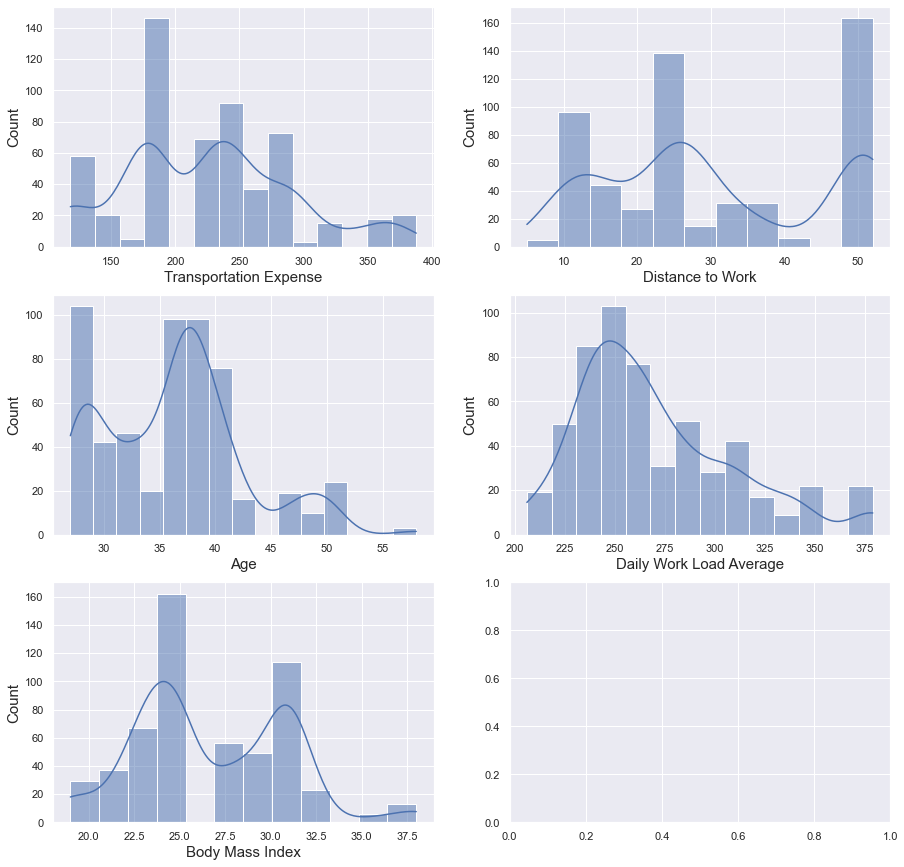

In [49]:
figure, axes = plt.subplots(3,2, figsize = (15,15))

for i, ax in zip(X_train.columns[:5], axes.flatten()):
    sns.histplot(x = i, data = X_train, kde = True, ax=ax);

All features do not follow a normal distribution. Hence, all of these feaures needs to be taken care of through transformation, discretization, etc.

### BMI

In [50]:
X_train['Body Mass Index'].describe()

count    556.000000
mean      26.724820
std        4.210433
min       19.000000
25%       24.000000
50%       25.000000
75%       31.000000
max       38.000000
Name: Body Mass Index, dtype: float64

The standard weight status categories associated with BMI ranges for adults are shown in the following table.

BMI	Weight Status:

**Below 18.5**:	Underweight

**18.5 – 24.9**:	Normal or Healthy Weight

**25.0 – 29.9**:	Overweight

**30.0 and Above**:	Obese

In [51]:
bins = [18,24.95,29.95, 39]
reasons = ['Healthy','OverWeight', 'Obese']

X_train['BMI_bin'] = pd.cut(x = X_train['Body Mass Index'], bins = bins, labels = reasons).astype('object')

X_test['BMI_bin'] = pd.cut(x = X_test['Body Mass Index'], bins = bins, labels = reasons).astype('object')

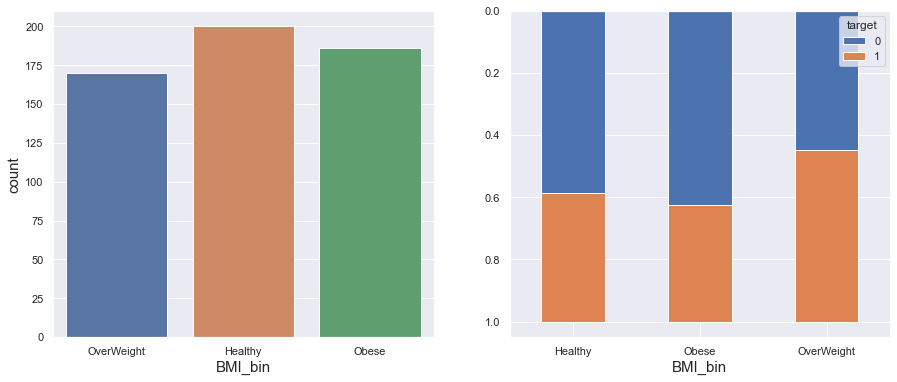

In [52]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

sns.countplot(X_train['BMI_bin'], ax = ax[0])


pd.crosstab(index = X_train['BMI_bin'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

#### Daily Work Load Average

In [53]:
def dignostic_plots(x):
    import scipy.stats as stats

    fig, ax = plt.subplots(1,3, figsize = (15,5))

    sns.histplot(x, kde = True, ax = ax[0]);
    sns.boxplot(x, ax = ax[1]);
    stats.probplot(x, dist="norm", plot=plt);

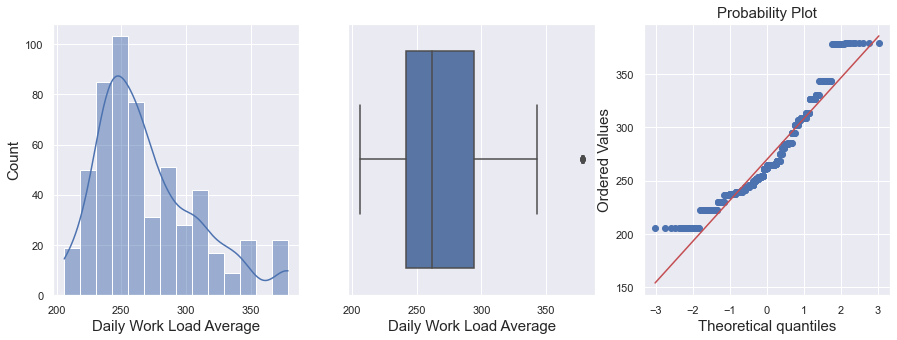

In [54]:
dignostic_plots(X_train['Daily Work Load Average'])

Due to presence of outliers, I will apply log transformation to transform the variable to follow a normal distribution. 

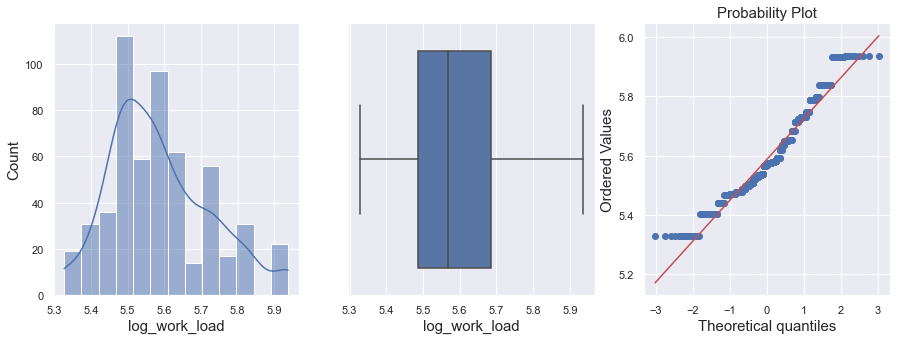

In [55]:
#log transformation

import feature_engine.transformation as vt

lt = vt.LogTransformer()
X_train['log_work_load'] = lt.fit_transform(X_train['Daily Work Load Average'].to_frame())

dignostic_plots(X_train['log_work_load'])

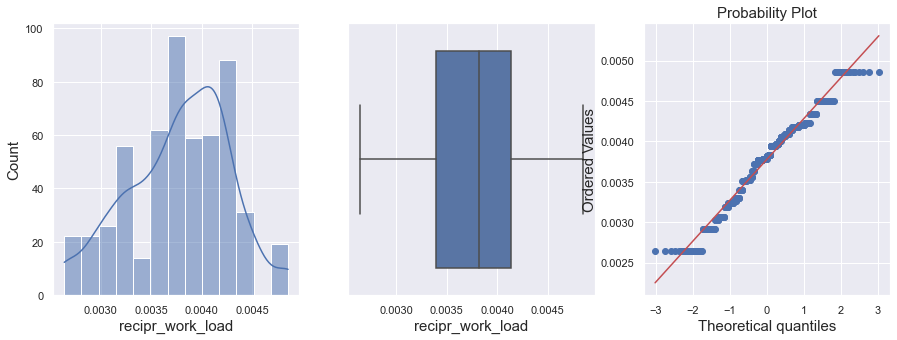

In [56]:
#reciprocal transformation

import feature_engine.transformation as vt

rt = vt.ReciprocalTransformer()
X_train['recipr_work_load'] = rt.fit_transform(X_train['Daily Work Load Average'].to_frame())

dignostic_plots(X_train['recipr_work_load'])

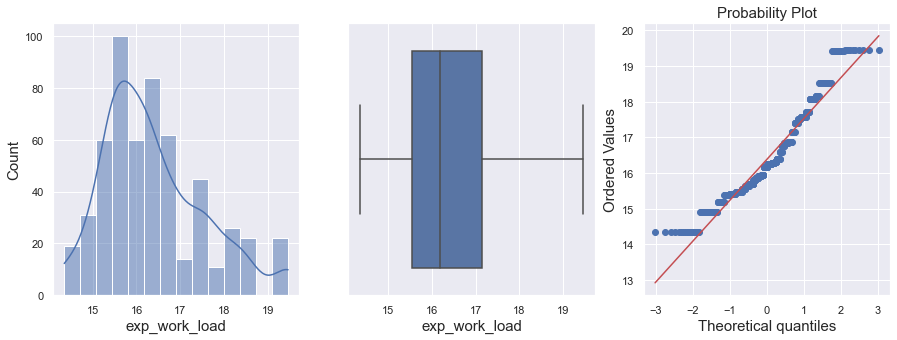

In [57]:
#exponential transformation

import feature_engine.transformation as vt

et = vt.PowerTransformer()
X_train['exp_work_load'] = et.fit_transform(X_train['Daily Work Load Average'].to_frame())

dignostic_plots(X_train['exp_work_load'])

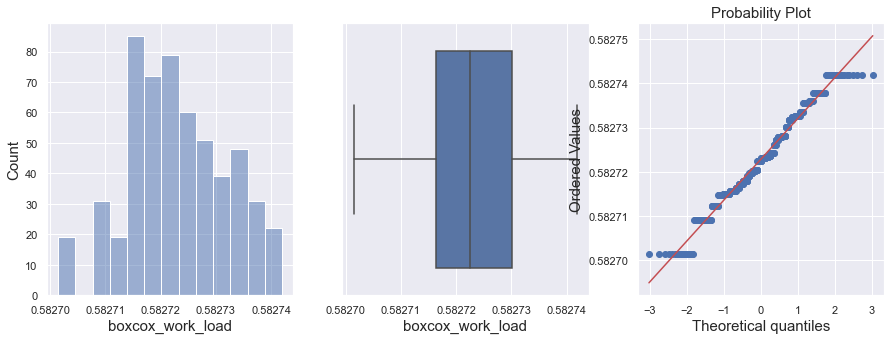

In [58]:
#boxcox transformation

import feature_engine.transformation as vt

bct = vt.BoxCoxTransformer()
X_train['boxcox_work_load'] = bct.fit_transform(X_train['Daily Work Load Average'].to_frame())

dignostic_plots(X_train['boxcox_work_load'])

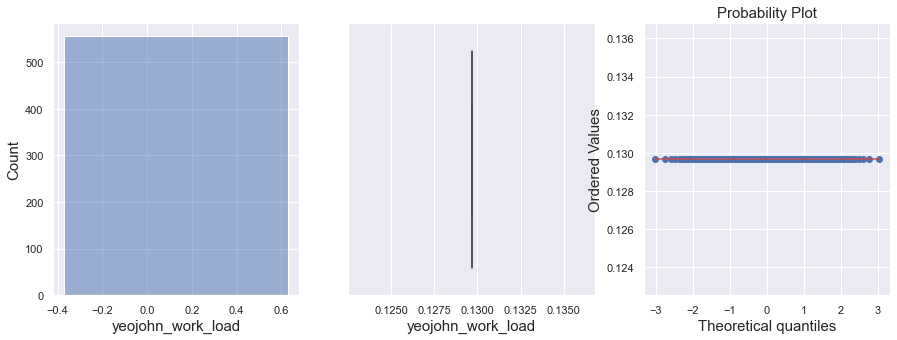

In [59]:
#yeojohnson transformation

import feature_engine.transformation as vt

yjt = vt.YeoJohnsonTransformer()
X_train['yeojohn_work_load'] = yjt.fit_transform(X_train['Daily Work Load Average'].to_frame())

dignostic_plots(X_train['yeojohn_work_load'])

In [60]:
X_train.iloc[:,-5:].describe().T[['mean', '50%']]

#I will go with boxcox transformation

,mean,50%
log_work_load,5.587963,5.567413
recipr_work_load,0.003779,0.003820
exp_work_load,16.386756,16.178875
boxcox_work_load,0.582723,0.582723
yeojohn_work_load,0.129662,0.129662


In [61]:
X_train.columns

Index(['Transportation Expense', 'Distance to Work', 'Age',
       'Daily Work Load Average', 'Body Mass Index', 'Day', 'Month', 'Seasons',
       'Reason_bin', 'household_size', 'has_collegedegree', 'BMI_bin',
       'log_work_load', 'recipr_work_load', 'exp_work_load',
       'boxcox_work_load', 'yeojohn_work_load'],
      dtype='object')

In [62]:
X_train.drop(['log_work_load', 'recipr_work_load', 'exp_work_load', 
              'yeojohn_work_load'], axis = 1, inplace = True)

X_test['boxcox_work_load'] = yjt.transform(X_test['Daily Work Load Average'].to_frame())

### Age

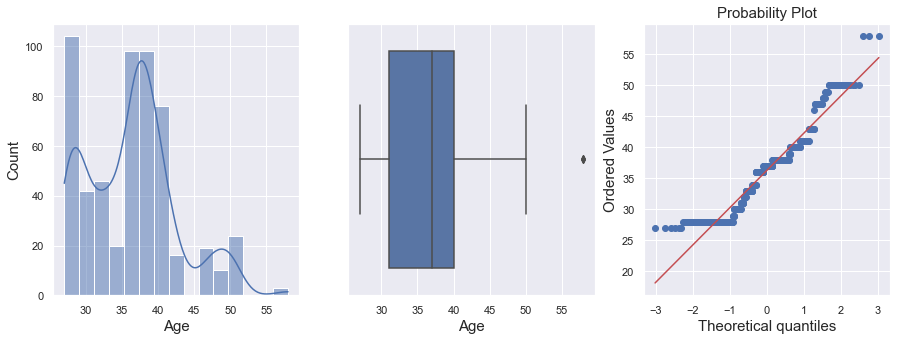

In [63]:
dignostic_plots(X_train['Age'])

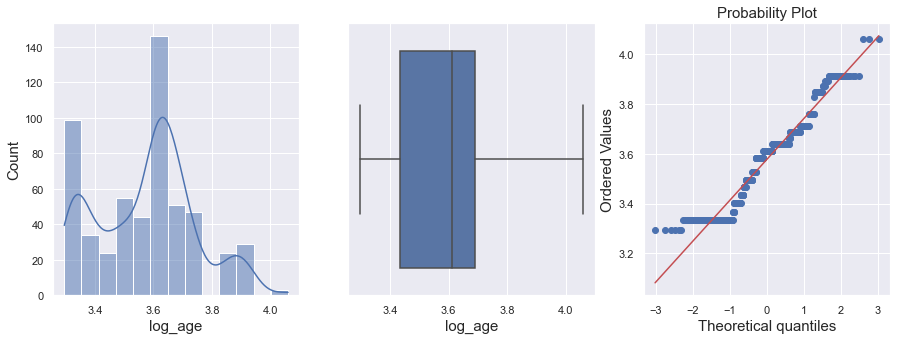

In [64]:
# Log transformation

lt = vt.LogTransformer()
X_train['log_age'] = lt.fit_transform(X_train['Age'].to_frame())

dignostic_plots(X_train['log_age'])

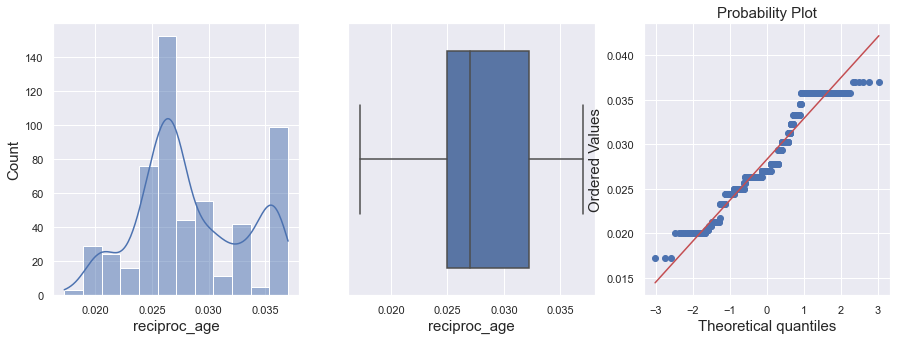

In [65]:
# Reciprocal transformation

rt = vt.ReciprocalTransformer()
X_train['reciproc_age'] = rt.fit_transform(X_train['Age'].to_frame())

dignostic_plots(X_train['reciproc_age'])

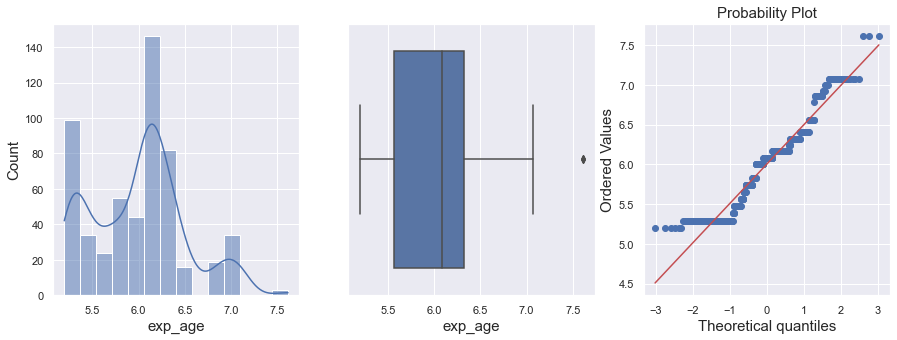

In [66]:
# exponential transformation

et = vt.PowerTransformer()
X_train['exp_age'] = et.fit_transform(X_train['Age'].to_frame())

dignostic_plots(X_train['exp_age'])

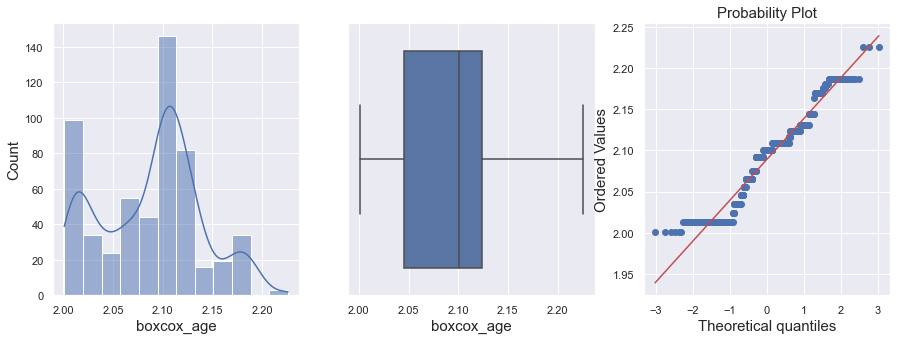

In [67]:
# boxcox transformation

bct = vt.BoxCoxTransformer()
X_train['boxcox_age'] = bct.fit_transform(X_train['Age'].to_frame())

dignostic_plots(X_train['boxcox_age'])

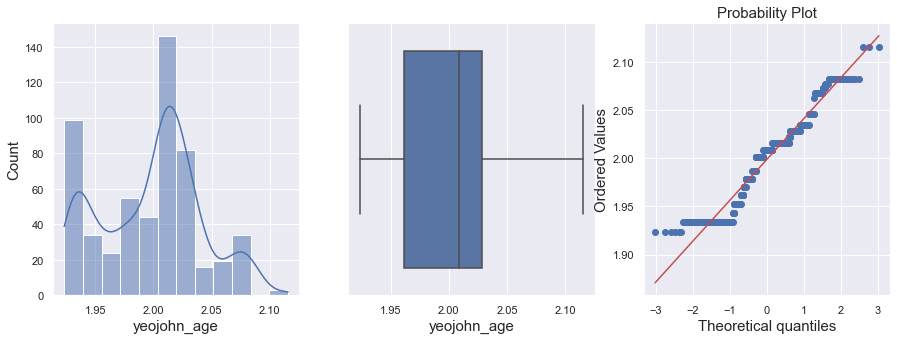

In [68]:
# yeojohnson transformation

yjt = vt.YeoJohnsonTransformer()
X_train['yeojohn_age'] = yjt.fit_transform(X_train['Age'].to_frame())

dignostic_plots(X_train['yeojohn_age'])

In [69]:
X_train.iloc[:,-5:].describe().T[['mean', '50%']]

,mean,50%
log_age,3.578113,3.610918
reciproc_age,0.028322,0.027027
exp_age,6.005038,6.082763
boxcox_age,2.089318,2.100654
yeojohn_age,1.998926,2.008591


None of the above transformations helped improve the distribution. Hence, I will bin the feature instead.

In [70]:
X_train.drop(['log_age', 'reciproc_age', 'exp_age', 'boxcox_age', 'yeojohn_age'], axis = 1, inplace = True)

In [71]:
X_train.Age.describe()

count    556.000000
mean      36.318345
std        6.198031
min       27.000000
25%       31.000000
50%       37.000000
75%       40.000000
max       58.000000
Name: Age, dtype: float64

In [72]:
bins = [26,29.5,40.5,60.5]
reasons = ['Twenties', 'Thirties', 'Senior']

X_train['Age_bin'] = pd.cut(x = X_train['Age'], bins = bins, labels = reasons).astype('object')
X_test['Age_bin'] = pd.cut(x = X_test['Age'], bins = bins, labels = reasons).astype('object')

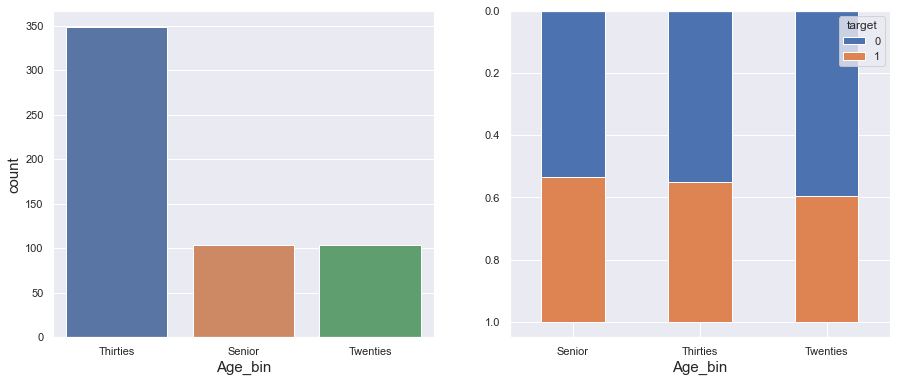

In [73]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

sns.countplot(X_train['Age_bin'], ax = ax[0])


pd.crosstab(index = X_train['Age_bin'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

#### Distance to work

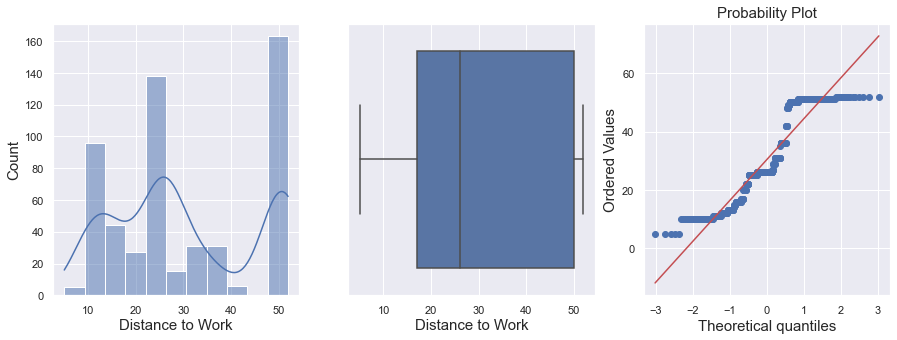

In [74]:
dignostic_plots(X_train['Distance to Work'])

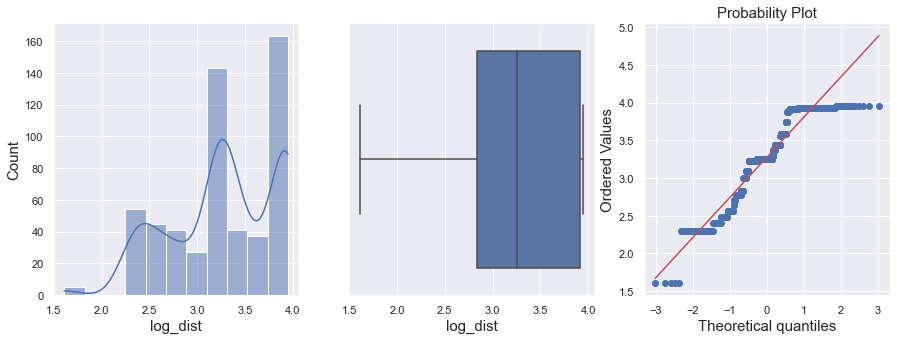

In [75]:
lt = vt.LogTransformer()
X_train['log_dist'] = lt.fit_transform(X_train['Distance to Work'].to_frame())

dignostic_plots(X_train['log_dist'])

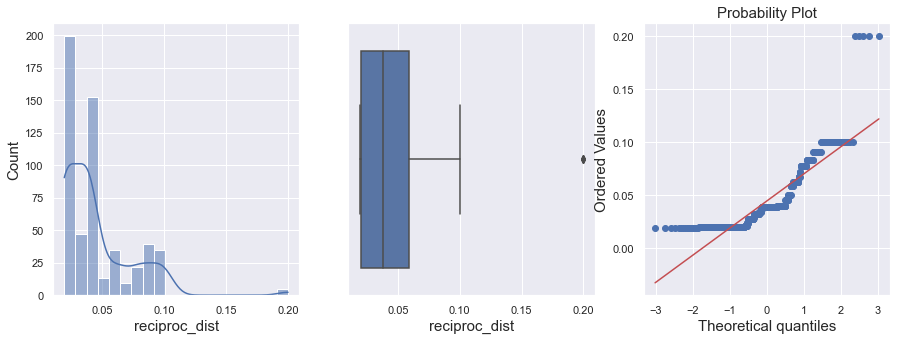

In [76]:
# Reciprocal transformation

rt = vt.ReciprocalTransformer()
X_train['reciproc_dist'] = rt.fit_transform(X_train['Distance to Work'].to_frame())

dignostic_plots(X_train['reciproc_dist'])

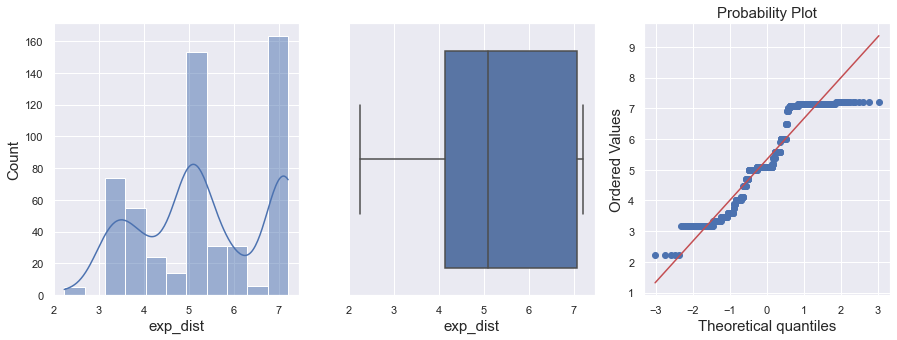

In [77]:
# exponential transformation

et = vt.PowerTransformer()
X_train['exp_dist'] = et.fit_transform(X_train['Distance to Work'].to_frame())

dignostic_plots(X_train['exp_dist'])

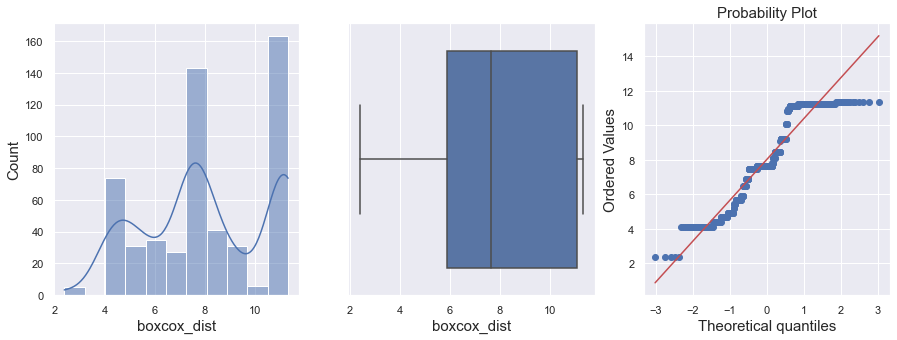

In [78]:
# boxcox transformation

bct = vt.BoxCoxTransformer()
X_train['boxcox_dist'] = bct.fit_transform(X_train['Distance to Work'].to_frame())

dignostic_plots(X_train['boxcox_dist'])

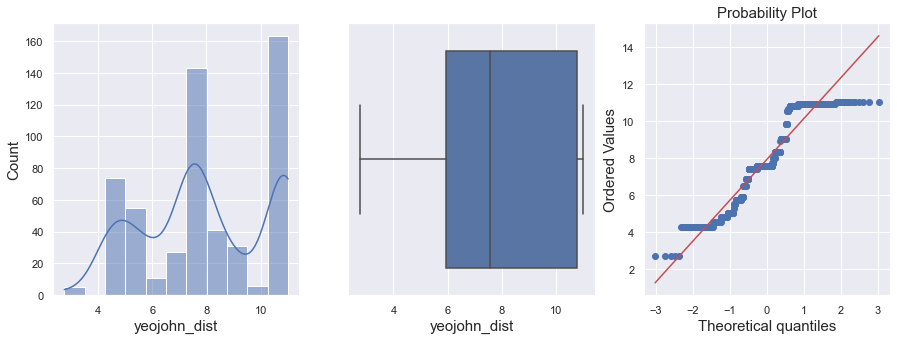

In [79]:
# yeojohnson transformation

yjt = vt.YeoJohnsonTransformer()
X_train['yeojohn_dist'] = yjt.fit_transform(X_train['Distance to Work'].to_frame())

dignostic_plots(X_train['yeojohn_dist'])

In [80]:
X_train.iloc[:,-5:].describe().T[['mean', '50%']]

,mean,50%
log_dist,3.277346,3.258097
reciproc_dist,0.044539,0.038462
exp_dist,5.341638,5.099020
boxcox_dist,8.029572,7.622069
yeojohn_dist,7.937108,7.553694


Similar to Age, the above transformations does not help with the distribution. This time I will equal frequency discretzation for this varibale.

In [81]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

disc = EqualFrequencyDiscretiser(q=4, return_object=True)

# find the intervals
X_train['dist_bin'] = disc.fit_transform(X_train['Distance to Work'].to_frame())

X_test['dist_bin'] = disc.transform(X_test['Distance to Work'].to_frame())

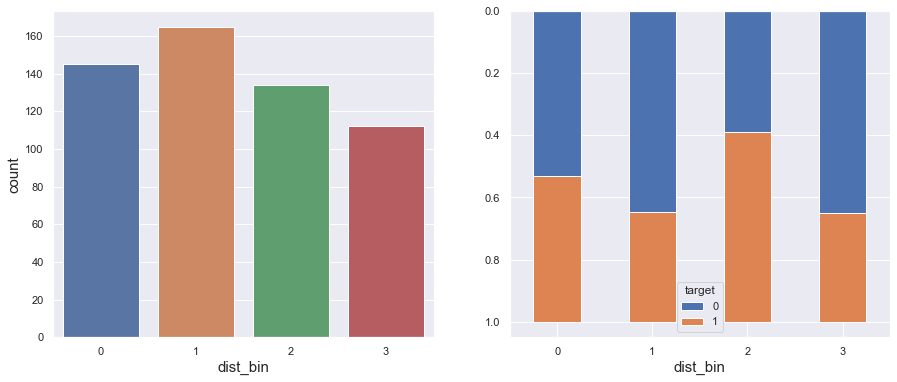

In [82]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

sns.countplot(X_train['dist_bin'], ax = ax[0])


pd.crosstab(index = X_train['dist_bin'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

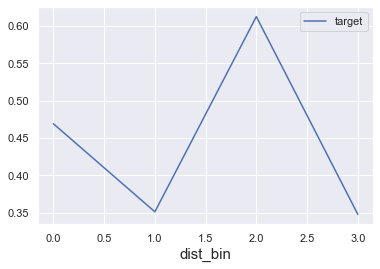

In [83]:
pd.concat([X_train['dist_bin'], y_train], axis=1).groupby('dist_bin').mean().plot();

In [84]:
enc = OrdinalEncoder(encoding_method = 'ordered')

enc.fit(X_train['dist_bin'].to_frame(), y_train)

X_train['ord_dist_bin'] = enc.transform(X_train['dist_bin'].to_frame())
X_test['ord_dist_bin'] = enc.transform(X_test['dist_bin'].to_frame())

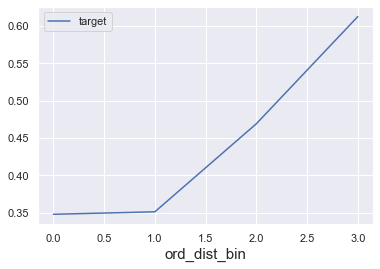

In [85]:
pd.concat([X_train['ord_dist_bin'], y_train], axis=1).groupby('ord_dist_bin').mean().plot();

A clear monotonic relationship is now clear between distance and the probability of being excessively absent.

In [86]:
X_train.drop(['Distance to Work', 'Age', 'Daily Work Load Average', 'Body Mass Index', 
             'log_dist', 'reciproc_dist', 'exp_dist', 'boxcox_dist', 'yeojohn_dist', 
              'dist_bin'], axis = 1, inplace = True)

X_test.drop(['Distance to Work', 'Age', 'Daily Work Load Average', 'Body Mass Index',
              'dist_bin'], axis = 1, inplace = True)

In [87]:
X_train.shape, X_test.shape

((556, 11), (62, 11))

#### Transportation expense

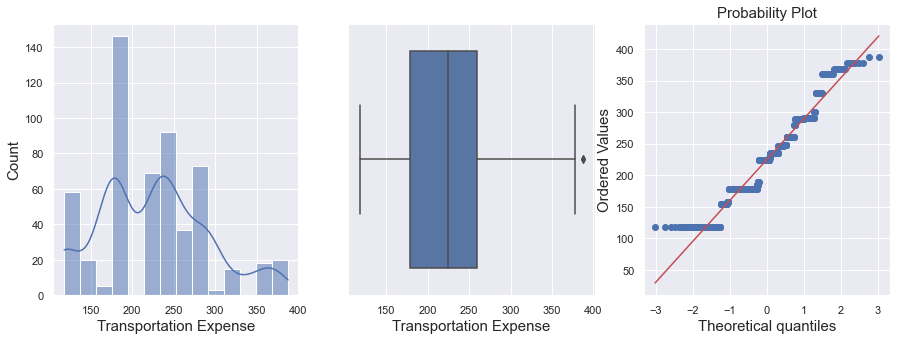

In [88]:
dignostic_plots(X_train['Transportation Expense'])

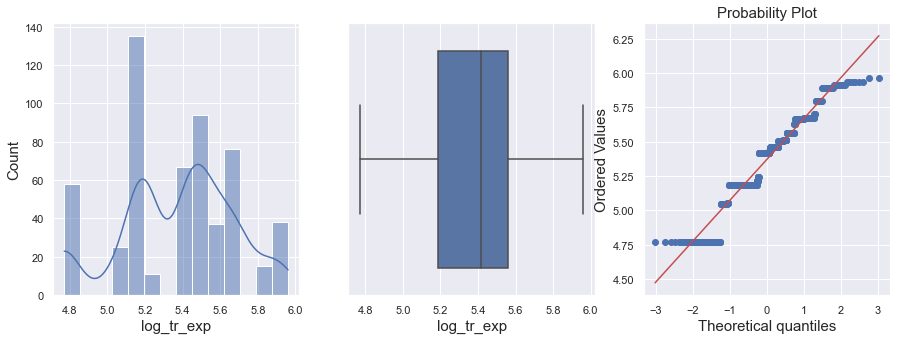

In [89]:
lt = vt.LogTransformer()
X_train['log_tr_exp'] = lt.fit_transform(X_train['Transportation Expense'].to_frame())

dignostic_plots(X_train['log_tr_exp'])

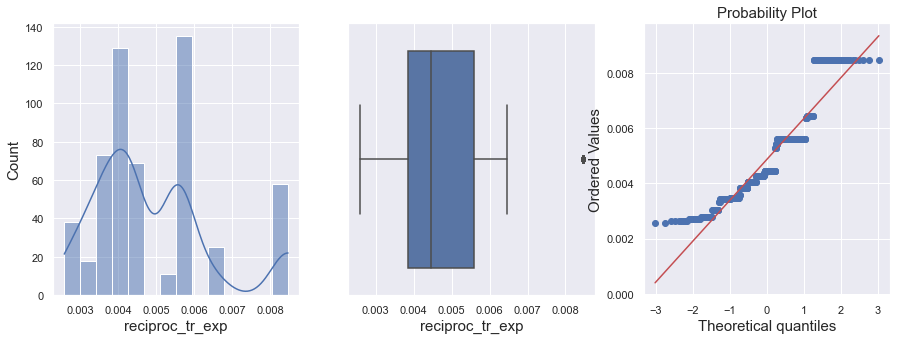

In [90]:
# Reciprocal transformation

rt = vt.ReciprocalTransformer()
X_train['reciproc_tr_exp'] = rt.fit_transform(X_train['Transportation Expense'].to_frame())

dignostic_plots(X_train['reciproc_tr_exp'])

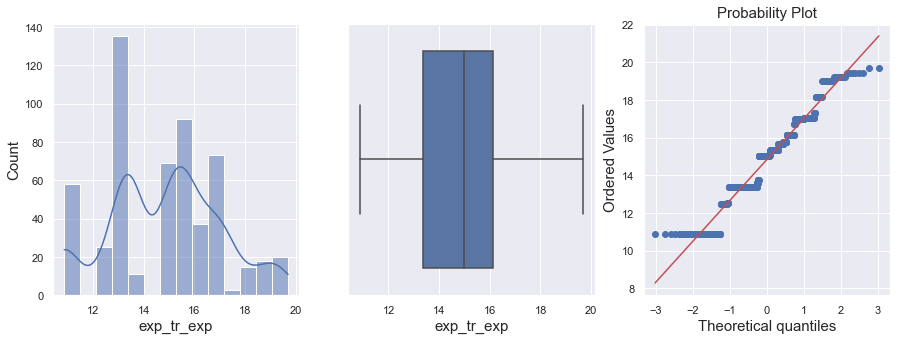

In [91]:
# exponential transformation

et = vt.PowerTransformer()
X_train['exp_tr_exp'] = et.fit_transform(X_train['Transportation Expense'].to_frame())

dignostic_plots(X_train['exp_tr_exp'])

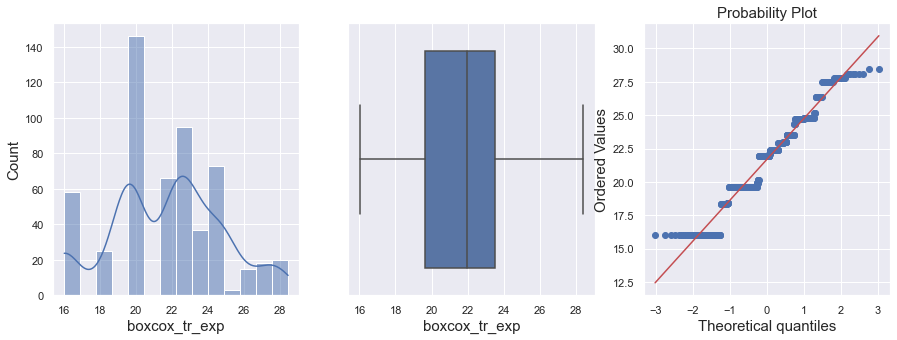

In [92]:
# boxcox transformation

bct = vt.BoxCoxTransformer()
X_train['boxcox_tr_exp'] = bct.fit_transform(X_train['Transportation Expense'].to_frame())

dignostic_plots(X_train['boxcox_tr_exp'])

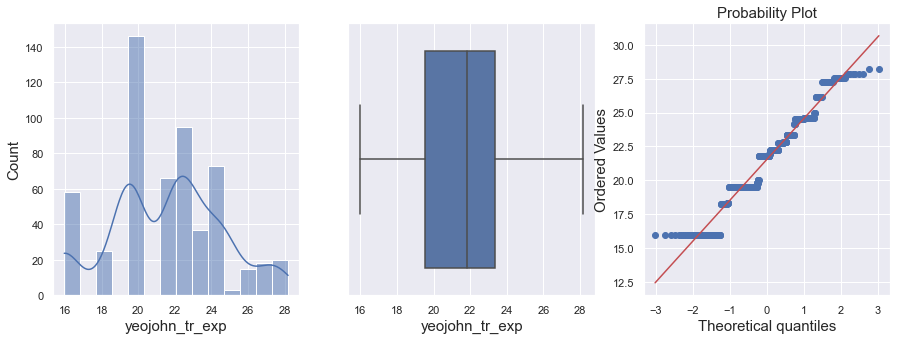

In [93]:
# yeojohnson transformation

yjt = vt.YeoJohnsonTransformer()
X_train['yeojohn_tr_exp'] = yjt.fit_transform(X_train['Transportation Expense'].to_frame())

dignostic_plots(X_train['yeojohn_tr_exp'])

In [94]:
X_train.iloc[:,-5:].describe().T[['mean', '50%']]

,mean,50%
log_tr_exp,5.372396,5.416100
reciproc_tr_exp,0.004869,0.004444
exp_tr_exp,14.843738,15.000000
boxcox_tr_exp,21.697134,21.947458
yeojohn_tr_exp,21.556774,21.803137


None of the transformations helped to improve the distribution. Same as before, I will bin this feature.

In [95]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.encoding import OrdinalEncoder

disc = EqualFrequencyDiscretiser(q=4, return_object=True)

# find the intervals
X_train['tr_exp_bin'] = disc.fit_transform(X_train['Transportation Expense'].to_frame())

X_test['tr_exp_bin'] = disc.transform(X_test['Transportation Expense'].to_frame())

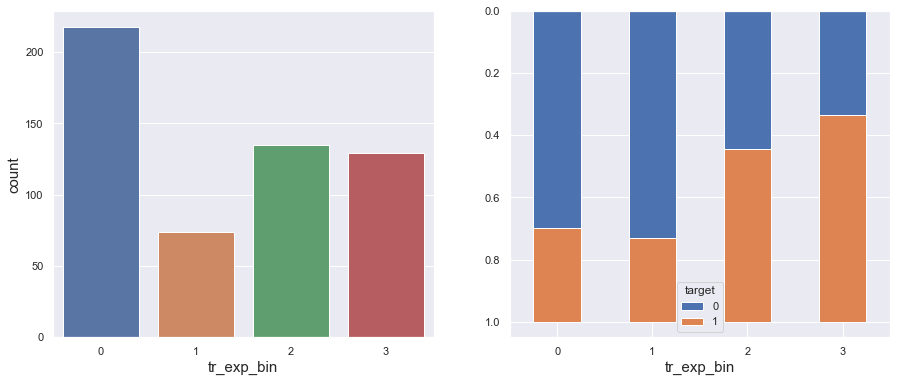

In [96]:
fig, ax = plt.subplots(1,2, figsize = (15,6))

sns.countplot(X_train['tr_exp_bin'], ax = ax[0])


pd.crosstab(index = X_train['tr_exp_bin'], columns = y_train.target).apply(lambda x: x/x.sum(), axis = 1).\
                                plot(kind = 'bar', stacked = True, rot = 0, ax = ax[1]);

plt.gca().invert_yaxis();

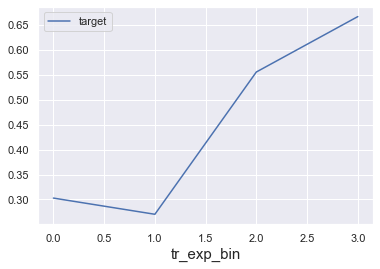

In [97]:
pd.concat([X_train['tr_exp_bin'], y_train], axis=1).groupby('tr_exp_bin').mean().plot();

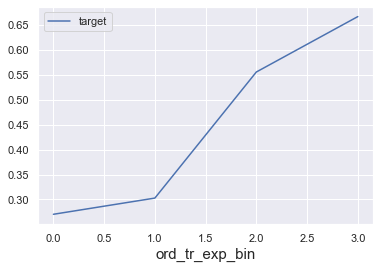

In [98]:
enc = OrdinalEncoder(encoding_method = 'ordered')

enc.fit(X_train['tr_exp_bin'].to_frame(), y_train)

X_train['ord_tr_exp_bin'] = enc.transform(X_train['tr_exp_bin'].to_frame())
X_test['ord_tr_exp_bin'] = enc.transform(X_test['tr_exp_bin'].to_frame())

pd.concat([X_train['ord_tr_exp_bin'], y_train], axis=1).groupby('ord_tr_exp_bin').mean().plot();

Now, a clear monotonic relation exist between binned transportation expense and target.

In [99]:
X_train.drop(['Transportation Expense', 'log_tr_exp', 'reciproc_tr_exp',
       'exp_tr_exp', 'boxcox_tr_exp', 'yeojohn_tr_exp', 'tr_exp_bin'], axis = 1, inplace = True)

X_test.drop(['Transportation Expense', 'tr_exp_bin'], axis = 1, inplace = True)

### Encoding Categorical features

Here, I will encode all of the categorical features to using probability ratio encoding

In [100]:
X_train.shape, X_test.shape

((556, 11), (62, 11))

In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 556 entries, 577 to 102
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Day                556 non-null    int64  
 1   Month              556 non-null    int64  
 2   Seasons            556 non-null    object 
 3   Reason_bin         556 non-null    object 
 4   household_size     556 non-null    object 
 5   has_collegedegree  556 non-null    int64  
 6   BMI_bin            556 non-null    object 
 7   boxcox_work_load   556 non-null    float64
 8   Age_bin            556 non-null    object 
 9   ord_dist_bin       556 non-null    int64  
 10  ord_tr_exp_bin     556 non-null    int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 72.1+ KB


In [102]:
cat_cols = [
    col for col in X_train.columns if (X_train[col].dtype=='object')
]

print(cat_cols)

['Seasons', 'Reason_bin', 'household_size', 'BMI_bin', 'Age_bin']


In [106]:
from feature_engine.encoding import PRatioEncoder

ratio_enc = PRatioEncoder(encoding_method = 'ratio', variables=cat_cols)

ratio_enc.fit(X_train, y_train['target'])
print(ratio_enc.encoder_dict_)

X_train = ratio_enc.transform(X_train)
X_test = ratio_enc.transform(X_test)

{'Seasons': {'Autumn': 0.8125, 'Spring': 0.7157894736842105, 'Summer': 0.5342465753424657, 'Winter': 1.2295081967213117}, 'Reason_bin': {'Disease': 2.742857142857143, 'Not Absent': 0.0, 'Other': 0.4893617021276595, 'Pregnancy': 1.0, 'Severe': 4.714285714285713}, 'household_size': {'empty': 0.5486111111111112, 'large_size': 1.1368421052631579, 'small_size': 0.8571428571428572}, 'BMI_bin': {'Healthy': 0.7094017094017094, 'Obese': 0.603448275862069, 'OverWeight': 1.236842105263158}, 'Age_bin': {'Senior': 0.8727272727272728, 'Thirties': 0.8177083333333333, 'Twenties': 0.6774193548387097}}


### Saving all to csv

In [107]:
X_train.to_csv('X_train.csv', index = False)
X_test.to_csv('X_test.csv', index = False)
y_train.to_csv('y_train.csv', index = False)
y_test.to_csv('y_test.csv', index = False)